In [1]:
import torch
print("torch.__version__",torch.__version__)
import mgplvm as mgp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import csv

np.random.seed(0)
torch.manual_seed(0)
print("torch.__version__",torch.__version__)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU
print(device)

torch.__version__ 1.7.1+cu101
loading
torch.__version__ 1.7.1+cu101
cuda


In [2]:
#mkdir -p data

In [47]:
#with open('data/fly_data.tsv', newline='') as csvfile:
    #fly_data = np.array(list(csv.reader(csvfile, delimiter='\t')))
#print(fly_data.shape)
#Y = np.expand_dims(fly_data, 2).astype(float).transpose((2, 0, 1))
time = 3500
neuron_num = 33
skip = 2
grid_data = np.loadtxt("spikegrid100_5000_e.csv", delimiter=",")[::3,::skip]
traj = np.loadtxt("trj_grid_e.csv", delimiter=",")[::skip,:]
#grid_data = np.loadtxt("spikegridbig100_5000_e.csv", delimiter=",")[::3,::skip]
##traj = np.loadtxt("trj_grid_e.csv", delimiter=",")[::skip,:]
#grid_data = np.loadtxt("spike_grid100_5000_sq.csv", delimiter=",")[::4,::skip]
#traj = np.loadtxt("trj5000_grid100_sq.csv", delimiter=",")[::skip,:]
#grid_data = np.loadtxt("spike149_nature_final.csv", delimiter=",")[::5,::skip]
#traj = np.loadtxt("trj5000_nature_final.csv", delimiter=",")[::skip,:]
print(traj.shape)
print(grid_data.shape)
Y = np.expand_dims(grid_data, 2).astype(float).transpose((2, 0, 1))
n_samples, n, m = Y.shape
print(n_samples, n, m)

(2500, 2)
(34, 2500)
1 34 2500


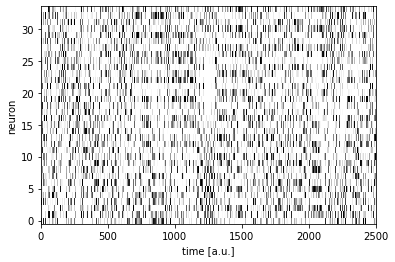

In [48]:
plt.figure()
Yplot = Y[0, :, :]
plt.imshow(Yplot, cmap='Greys', aspect='auto', origin = 'upper')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,traj.shape[0])
plt.ylim(-0.5,n-0.5)
plt.show()
plt.close()

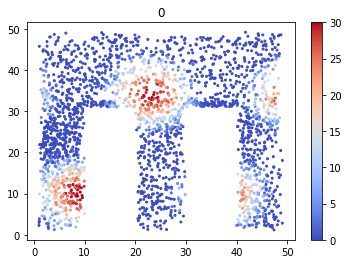

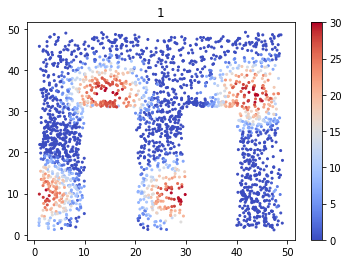

In [49]:
for i in range(2):
    fig, ax = plt.subplots()
    mappable = ax.scatter(traj[:,0], traj[:,1], c=grid_data[i,:] ,cmap='coolwarm',vmin=0,s=4)
    fig.colorbar(mappable)
    plt.title(i)
    plt.show()

In [50]:
d = 2  # dims of latent space
n_z = 20  # number of inducing points #15
n_samples = 1  # number of samples 1
def build_model():
    # specify manifold, kernel and rdist
    manif = mgp.manifolds.Torus(m, d)  # latent distribution manifold
    print(manif.distance)
    lat_dist = mgp.rdist.ReLie(manif, m, n_samples)  # construct ReLie distribution
    # Note: we construct the kernel and likelihood by passing the data in for initialization
    kernel = mgp.kernels.QuadExp(
        n, manif.distance
    )  # Use an exponential quadratic (RBF) kernel
    lik = mgp.likelihoods.Gaussian(n)  # Gaussian likelihood
    #lprior = mgp.lpriors.Uniform(manif)  # Prior on the manifold distribution
    lprior = mgp.lpriors.Brownian(manif, fixed_brownian_c = True, fixed_brownian_eta = False, brownian_eta = torch.ones(d)*2**2)
    z = manif.inducing_points(n, n_z)  # build inducing points
    model = mgp.models.SvgpLvm(
        n, m, n_samples, z, kernel, lik, lat_dist, lprior, whiten=True
    ).to(device)
    return model

In [51]:
data = torch.tensor(Y, device=device, dtype=torch.get_default_dtype())
model = build_model()

#train_params = mgp.crossval.training_params(max_steps = 1500, n_mc = 16, lrate = 5e-2, print_every = 100, burnin = 50)
train_params = mgp.crossval.training_params(max_steps = 3500, n_mc = 24, lrate = 4e-2, print_every = 100, burnin = 50)
progress = mgp.crossval.train_model(model, data, train_params) # train model

<function Torus.distance at 0x0000024CCAB60400>
iter   0 | elbo -57.720 | kl  0.006 | loss  57.720 | |mu| 0.106 | sig 1.500 | scale 1.000 | ell 2.000 | lik_sig 1.000 | brownian_c 0.000 | brownian_eta 4.000 |
iter 100 | elbo -14.612 | kl  0.026 | loss  14.635 | |mu| 0.914 | sig 0.535 | scale 0.825 | ell 1.243 | lik_sig 1.611 | brownian_c 0.000 | brownian_eta 0.739 |
iter 200 | elbo -6.268 | kl  0.056 | loss  6.323 | |mu| 1.283 | sig 0.224 | scale 0.923 | ell 0.872 | lik_sig 2.084 | brownian_c 0.000 | brownian_eta 0.354 |
iter 300 | elbo -3.883 | kl  0.084 | loss  3.968 | |mu| 1.434 | sig 0.133 | scale 1.034 | ell 0.734 | lik_sig 2.316 | brownian_c 0.000 | brownian_eta 0.336 |
iter 400 | elbo -3.083 | kl  0.105 | loss  3.188 | |mu| 1.459 | sig 0.095 | scale 1.089 | ell 0.661 | lik_sig 2.425 | brownian_c 0.000 | brownian_eta 0.340 |
iter 500 | elbo -2.744 | kl  0.119 | loss  2.863 | |mu| 1.491 | sig 0.074 | scale 1.113 | ell 0.628 | lik_sig 2.475 | brownian_c 0.000 | brownian_eta 0.332 |


In [52]:
#train_params = mgp.crossval.training_params(max_steps = 1000, n_mc = 13, lrate = 1e-3, print_every = 100, burnin = 50)
#progress = mgp.crossval.train_model(model, data, train_params) # train model

In [53]:
#thetas = model.lat_dist.prms[1] #mgplvm prediction
thetas = model.lat_dist.prms[0].detach().cpu().numpy()[0, :, :] % (2*np.pi) #mgplvm prediction
print(thetas.shape)
thetas2 = model.lat_dist.prms[1].detach().cpu().numpy()[0, :, :] % (2*np.pi) #mgplvm prediction
print(thetas2.shape)

(2500, 2)
(2500, 2, 2)


(2500,)


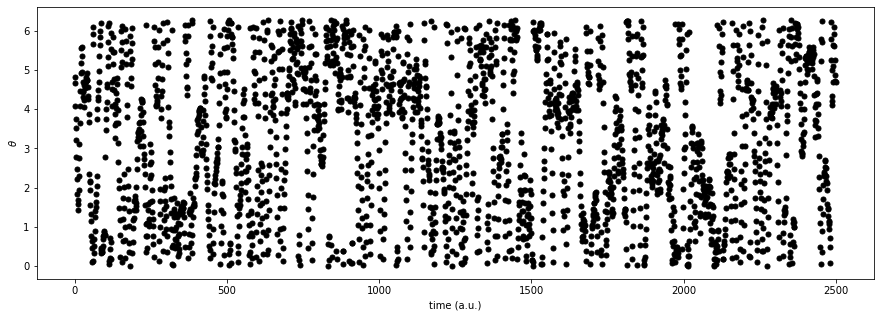

In [54]:
thetas0 = model.lat_dist.prms[0].detach().cpu().numpy()[0, :, 0] % (2*np.pi) #mgplvm prediction
print(thetas0.shape)
plt.figure(figsize=(15,5))
plt.scatter(np.arange(len(thetas)), thetas0, marker = ".", color = "k", s = 100)
#for i in range(len(thetas)-1):
  #x1, x2 = thetas[i], thetas[i+1]
  #if np.abs(x1-x2) < np.pi: plt.plot([i, i+1], [x1, x2], "k-")
plt.xlabel('time (a.u.)')
plt.ylabel(r'$\theta$')
plt.show()

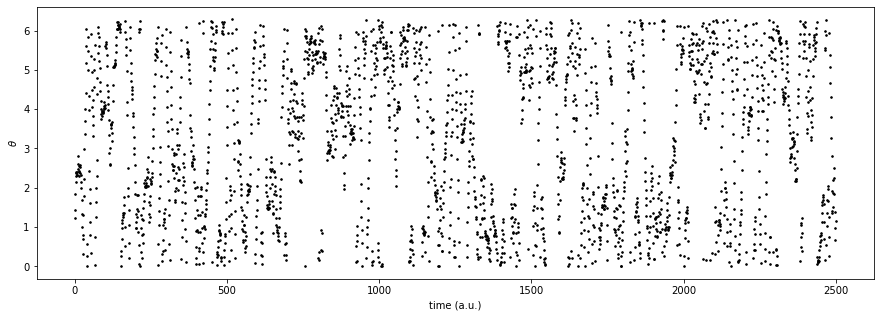

In [55]:
thetas1 = model.lat_dist.prms[0].detach().cpu().numpy()[0, :, 1] % (2*np.pi) #mgplvm prediction
plt.figure(figsize=(15,5))
plt.scatter(np.arange(len(thetas)), thetas1, marker = ".", color = "k", s = 10)
#plt.plot(thetas1, marker = ".", color = "k")
#for i in range(len(thetas)-1):
  #x1, x2 = thetas1[i], thetas1[i+1]
  #if np.abs(x1-x2) < np.pi: plt.plot([i, i+1], [x1, x2], "k-")
plt.xlabel('time (a.u.)')
plt.ylabel(r'$\theta$')
plt.show()

C:\Users\kdais\Anaconda3\envs\vdaisuke\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


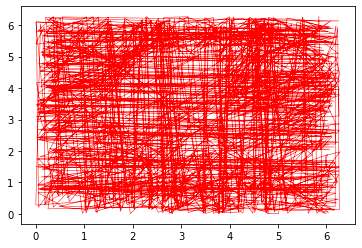

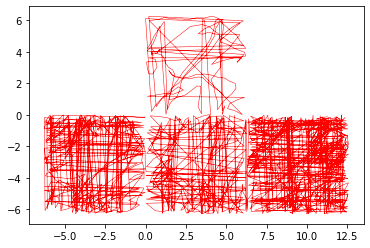

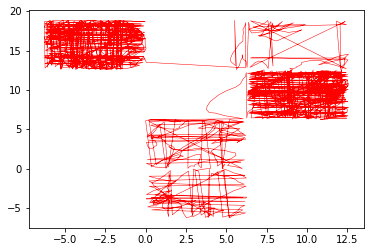

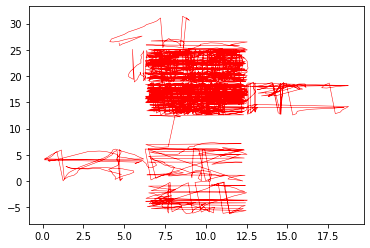

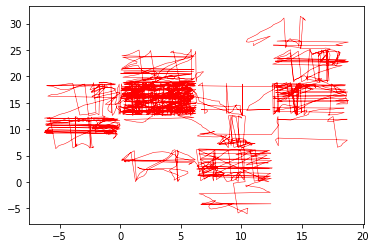

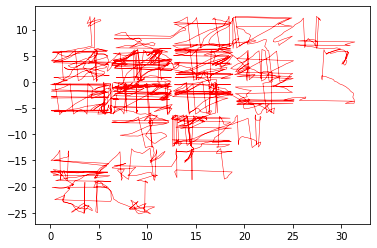

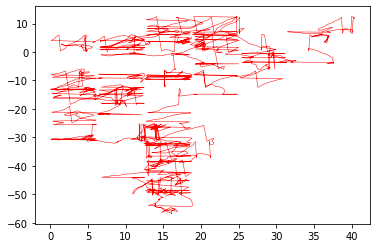

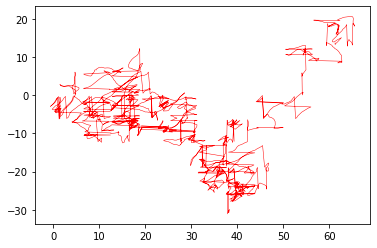

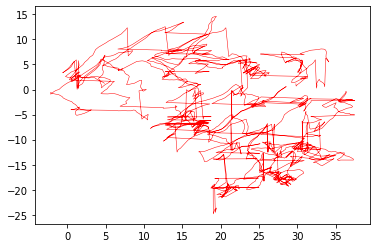

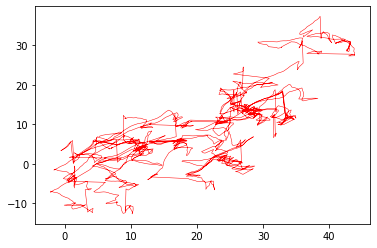

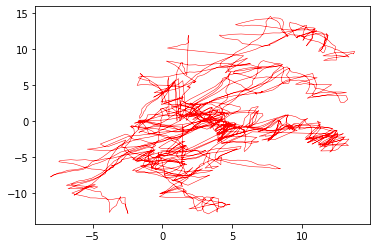

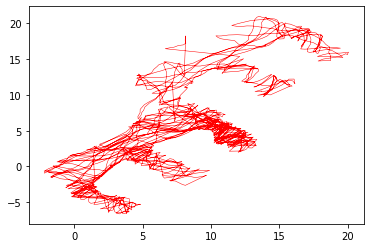

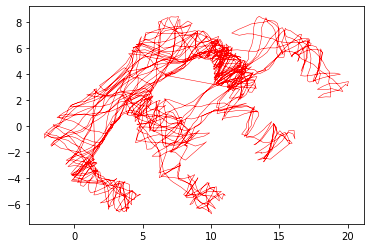

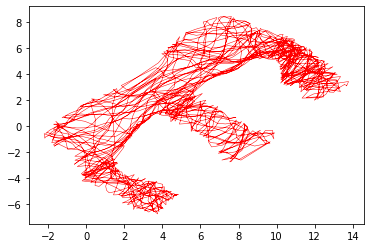

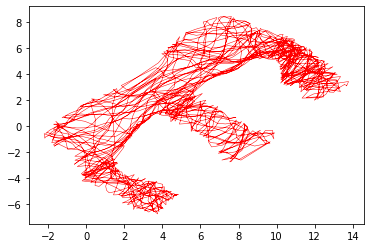

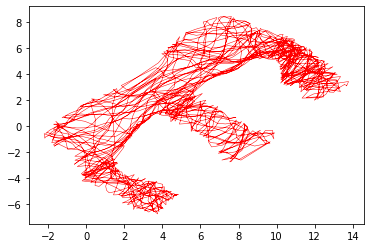

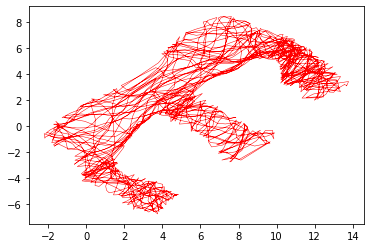

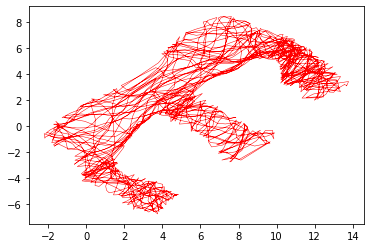

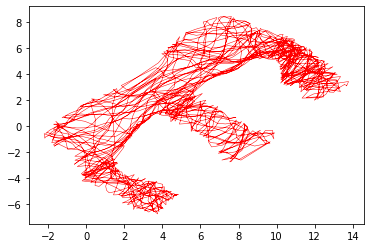

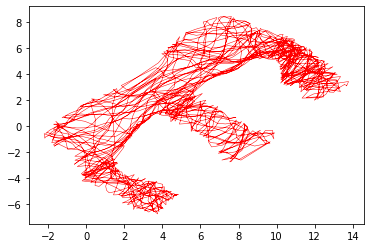

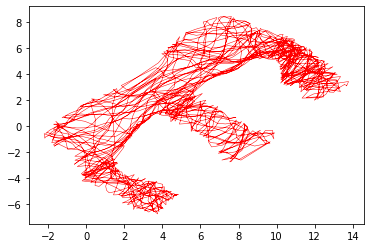

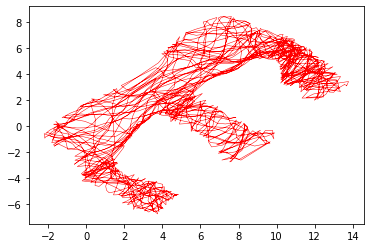

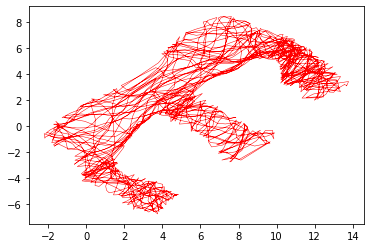

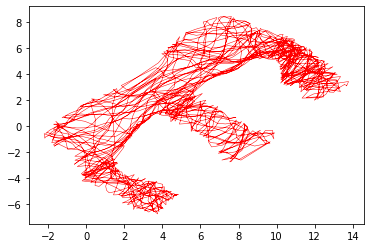

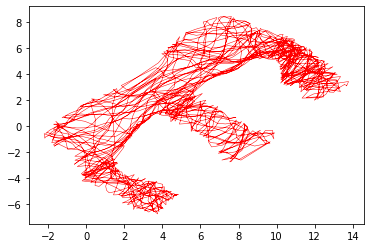

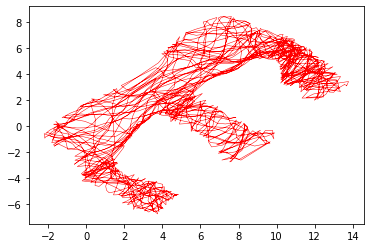

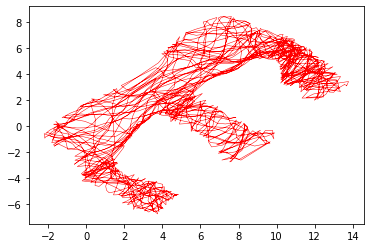

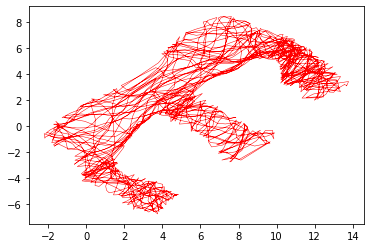

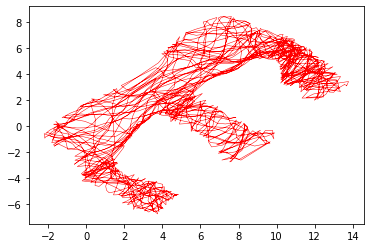

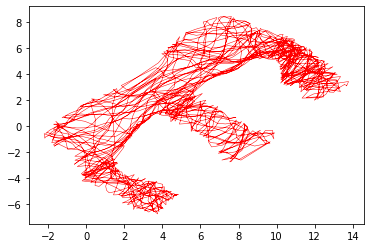

In [56]:
threshold = .0
for t in range(30):
    thetas_b = np.copy(thetas)
    for i in range(traj.shape[0]-1):
        #print(thetas.shape)
        if thetas_b[i+1,0] - thetas_b[i,0] > 2*np.pi-threshold - t/15:
            thetas_b[i+1:,0] -= 2*np.pi#qz_est_norm[i+1,0] - qz_est_norm[i,0]
        if thetas_b[i+1,1] - thetas_b[i,1] > 2*np.pi-threshold - t/15:
            thetas_b[i+1:,1] -= 2*np.pi#qz_est_norm[i+1,1] - qz_est_norm[i,1]
        if thetas_b[i+1,0] - thetas_b[i,0] < - 2*np.pi+threshold + t/15:
            thetas_b[i+1:,0] += 2*np.pi#qz_est_norm[i,0] - qz_est_norm[i+1,0]
        if thetas_b[i+1,1] - thetas_b[i,1] < - 2*np.pi+threshold + t/15:
            thetas_b[i+1:,1] += 2*np.pi#qz_est_norm[i,1] - qz_est_norm[i+1,1]

    #R = funs.compute_optimal_rotation(traj[:time,:],thetas, scale=0)
    #theta = -np.pi/6 - np.pi
    #R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    #R = np.array([[1, np.sin(theta)],[0, np.cos(theta)]])
    #R = np.array([[0, 1],[1, -1.73]])
    #qz_est_norm = qz_est_norm.dot(R)
    #plt.scatter(qz_est_norm[:,0],qz_est_norm[:,1])
    plt.figure()
    plt.plot(thetas_b[:,0],thetas_b[:,1],c="r",linewidth=.5)